In [1]:
# BATS (DG35 2014)
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import gsw
import scipy.io as si
from scipy.optimize import fmin
from scipy.signal import savgol_filter
from netCDF4 import Dataset
import pickle
import datetime
import pickle
# functions I've written 
from glider_cross_section import Glider
from mode_decompositions import eta_fit, vertical_modes, PE_Tide_GM, vertical_modes_f
from toolkit import spectrum_fit, nanseg_interp, plot_pro, find_nearest

# matplotlib.rcParams['figure.figsize'] = (14,10)

# --- PHYSICAL PARAMETERS
g = 9.81
rho0 = 1025  # - 1027
ref_lat = 31.7
ref_lon = 64.2
f_ref = np.pi * np.sin(np.deg2rad(ref_lat)) / (12 * 1800)
# --- MODE PARAMETERS
# frequency zeroed for geostrophic modes
omega = 0
# highest baroclinic mode to be calculated
mmax = 45
nmodes = mmax + 1
# maximum allowed deep shear [m/s/km]
deep_shr_max = 0.1
# minimum depth for which shear is limited [m]
deep_shr_max_dep = 3500
eta_fit_depth_min = 250
eta_fit_depth_max = 3750  # 3900
# --- BIN PARAMETERS
GD = Dataset('BATs_2015_gridded_apr04.nc', 'r')
bin_depth = GD.variables['grid'][:]

# ----------------------------------------------------------------------------------------------------------------------
# ---- PROCESSING USING GLIDER PACKAGE
gs = 84
ge = 142
x = Glider(35, np.arange(gs, ge + 1), '/Users/jake/Documents/baroclinic_modes/DG/BATS_2014/sg035')

# Test alternate density computation
import_dg = si.loadmat('/Users/jake/Documents/baroclinic_modes/sg035_2014_neutral_density_bin.mat')
dg_data = import_dg['out']
limm = 450
profile_tags = dg_data['prof_number'][0][0][0]
if profile_tags[0] == gs:
    first = 0
else:
    first = np.where(profile_tags < gs)[0][-1] + 1
if profile_tags[-1] == ge + 0.5:
    last = len(profile_tags)
else:
    last = np.where(profile_tags > ge)[0][0] - 1
d_in = range(first, last)
profile_tags = profile_tags[d_in]
neutral_density = dg_data['Neut_den'][0][0][0:limm, d_in]
t = dg_data['Temp'][0][0][0:limm, d_in]
s = dg_data['Sal'][0][0][0:limm, d_in]
lon = dg_data['Lon'][0][0][0:limm, d_in]
lat = dg_data['Lat'][0][0][0:limm, d_in]
dac_u = dg_data['Dac_u'][0][0][0]
dac_v = dg_data['Dac_v'][0][0][0]
d_time = dg_data['Time'][0][0][0:limm, d_in] - 366
t_s = datetime.date.fromordinal(np.int(np.nanmin(d_time)))
t_e = datetime.date.fromordinal(np.int(np.nanmax(d_time)))
ref_lat = np.nanmean(lat)
time_rec_bin = np.nanmean(d_time, axis=0)
grid = dg_data['Depth'][0][0][0:limm, 0]
grid_p = gsw.p_from_z(-1 * grid, ref_lat)
grid_p[0] = 0
z = -1 * grid
sz_g = grid.shape[0]



In [2]:
# -- Compute density
sa, ct, theta, sig0, sig2, dg_N2 = x.density(grid, ref_lat, t, s, lon, lat)

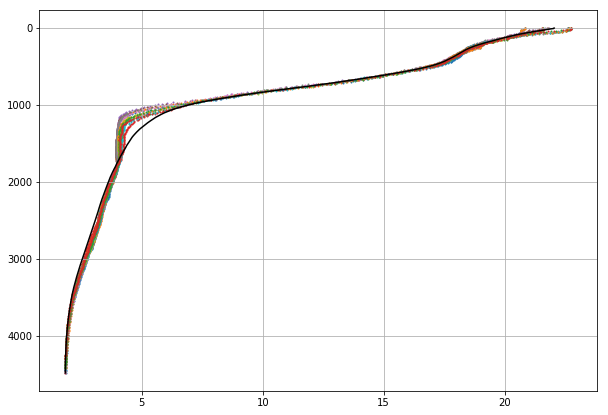

[ 107.5  108.   113.5  114.   115.5  116.   124.5  125.   125.5  126.
  126.5  127.   128.5  129. ]


In [96]:
# find eddy profiles 
edd_in = np.zeros(len(profile_tags))
for i in range(len(profile_tags)):
    t_an = (ct[:, i] - np.nanmean(ct, axis=1))
    if t_an[165] < -0.3:
        edd_in[i] = True      

f, ax = plt.subplots()
for i in range(len(profile_tags)):
    if edd_in[i] > 0:
        ax.scatter(ct[:, i], grid, s=1) 
ax.plot(np.nanmean(cons_t_avg, axis=1), grid, color='k')        
# ax.set_ylim([1000, 1500])        
ax.invert_yaxis()    
plot_pro(ax)

edds = profile_tags[edd_in > 0] 
print(edds)

In [97]:
# -- Background density profiles and seasonal variability
# 2014 mission was short enough that we don't need seasonal background averages 

# will split into 4 regions 
# split to account for horizontal gradients (should split for onshore/offshore of bermuda)
lon_lim = -64.09  # mid_split in lon
lat_lim = 31.65  # mid_split in lat 
# four boxes will be top left to bottom right clockwise 

# three seasons (winter, summer, fall)
# bounds are June 1 and Sept 15

# Winter 
d_b_1 = np.where( (np.nanmean(lon, axis=0) < lon_lim) & ((np.nanmean(lat, axis=0) > lat_lim)) 
                & ((profile_tags < 107) | (profile_tags > 129)))[0]
d_b_2 = np.where( (np.nanmean(lon, axis=0) > lon_lim) & ((np.nanmean(lat, axis=0) > lat_lim)) 
                & ((profile_tags < 107) | (profile_tags > 129)))[0]
d_b_3 = np.where( (np.nanmean(lon, axis=0) > lon_lim) & ((np.nanmean(lat, axis=0) < lat_lim)) 
                & ((profile_tags < 107) | (profile_tags > 129)))[0]
d_b_4 = np.where( (np.nanmean(lon, axis=0) < lon_lim) & ((np.nanmean(lat, axis=0) < lat_lim)) 
                & ((profile_tags < 107) | (profile_tags > 129)))[0]

bckgrds = [d_b_1, d_b_2, d_b_3, d_b_4]
bckgrds_info = ['b_1', 'b_2', 'b_3', 'b_4']

salin_avg = np.nan * np.zeros((len(grid), len(bckgrds)))
cons_t_avg = np.nan * np.zeros((len(grid), len(bckgrds)))
theta_avg = np.nan * np.zeros((len(grid), len(bckgrds)))
sigma_theta_avg = np.nan * np.zeros((len(grid), len(bckgrds)))
ddz_avg_sigma = np.nan * np.zeros((len(grid), len(bckgrds)))
N2_0 = np.nan * np.zeros(sigma_theta_avg.shape)
N2_ref = np.nan * np.zeros(sigma_theta_avg.shape)
N = np.nan * np.zeros(sigma_theta_avg.shape)
for i in range(len(bckgrds)):
    inn = bckgrds[i]
    salin_avg[:, i] = np.nanmean(sa[:, inn], axis=1)
    cons_t_avg[:, i] = np.nanmean(ct[:, inn], axis=1)
    theta_avg[:, i] = np.nanmean(theta[:, inn], axis=1)
    sigma_theta_avg[:, i] = np.nanmean(neutral_density[:, inn], axis=1)
    ddz_avg_sigma[:, i] = np.gradient(sigma_theta_avg[:, i], z)
    go = ~np.isnan(salin_avg[:, i])
    N2_0[np.where(go)[0][0:-1], i] = gsw.Nsquared(salin_avg[go, i], cons_t_avg[go, i], grid_p[go], lat=ref_lat)[0]
    N2_0[N2_0[:, i] < 0] = np.nan  # 1 * 10**-7
    N2_ref[:, i] = nanseg_interp(grid, N2_0[:, i])
    # N2_ref[:, i] = savgol_filter(N2_ref[:, i], 5, 3)
N2_ref[-1, :] = N2_ref[-2, :] - 1 * 10**-9
N2 = N2_ref.copy()

N2_all = np.nan * np.zeros(len(grid))
N2_all[0:-1] = gsw.Nsquared(np.nanmean(salin_avg, axis=1), np.nanmean(cons_t_avg, axis=1), grid_p, lat=ref_lat)[0]
for i in range(-15, 0):
    N2_all[i] = N2_all[i - 1] - 0.00000001
N2_all[N2_all < 0] = np.nan
N2_all = nanseg_interp(grid, N2_all)
N_all = np.sqrt(N2_all)
N2_all = savgol_filter(N2_all, 5, 3)
N2_all[N2_all < 0] = np.nan
N2_all = nanseg_interp(grid, N2_all)

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:36: RuntimeWarning: Mean of empty slice
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:37: RuntimeWarning: Mean of empty slice
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:38: RuntimeWarning: Mean of empty slice
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:39: RuntimeWarning: Mean of empty slice


In [101]:
len(d_b_4)

14

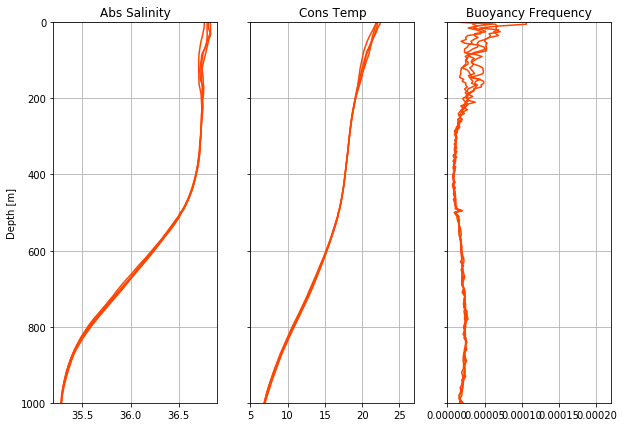

()

In [81]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
coli = '#FF4500', '#FF4500', '#FF4500', '#FF4500', '#2F4F4F', '#2F4F4F', '#2F4F4F', '#2F4F4F', '#DAA520', '#DAA520', '#DAA520', '#DAA520'
# cols = ['#2F4F4F', '#FF4500', '#DAA520']
# season_labs = ['Feb-Apr', 'May-Sept', 'Sept-Nov']
for i in range(len(bckgrds)):
    ax1.plot(salin_avg[:, i], grid, color=coli[i])
    ax2.plot(cons_t_avg[:, i], grid, color=coli[i])
    ax3.plot(N2_ref[:, i], grid, color=coli[i])
ax1.set_ylim([0, 1000])
ax1.grid()
ax2.grid()
ax1.invert_yaxis()
ax1.set_xlim([35.2, 36.9])
ax1.set_ylabel('Depth [m]')
ax1.set_title('Abs Salinity')
ax2.set_xlim([5, 27])
ax2.set_title('Cons Temp')
ax3.set_xlim([0, 0.00022])
ax3.set_title('Buoyancy Frequency')
plot_pro(ax3)

In [17]:
len(d_b_4)

32

In [5]:
# -- compute M/W sections and compute velocity
# -- USING X.TRANSECT_CROSS_SECTION_1 (THIS WILL SEPARATE TRANSECTS BY TARGET OF EACH DIVE)
sigth_levels = np.concatenate(
    [np.arange(23, 26.5, 0.5), np.arange(26.2, 27.2, 0.2),
     np.arange(27.2, 27.7, 0.2), np.arange(27.7, 28, 0.02), np.arange(28, 28.15, 0.01)])
# sigth_levels = np.concatenate([np.aranger(32, 36.6, 0.2), np.arange(36.6, 36.8, 0.05), np.arange(36.8, 37.4, 0.02)])

# --- SAVE so that we dont have to run transects every time
savee = 0
if savee > 0:
    ds, dist, avg_ct_per_dep_0, avg_sa_per_dep_0, avg_sig0_per_dep_0, v_g, vbt, isopycdep, isopycx, mwe_lon, mwe_lat,\
    DACe_MW, DACn_MW, profile_tags_per, shear, v_g_east, v_g_north = x.transect_cross_section_1(grid, neutral_density,
                                                                                                ct, sa, lon, lat,
                                                                                                dac_u, dac_v,
                                                                                                profile_tags,
                                                                                                sigth_levels)
    my_dict = {'ds': ds, 'dist': dist, 'avg_ct_per_dep_0': avg_ct_per_dep_0,
               'avg_sa_per_dep_0': avg_sa_per_dep_0, 'avg_sig0_per_dep_0': avg_sig0_per_dep_0, 'v_g': v_g, 'vbt': vbt,
               'isopycdep': isopycdep, 'isopycx': isopycx, 'mwe_lon': mwe_lon, 'mwe_lat': mwe_lat, 'DACe_MW': DACe_MW,
               'DACn_MW': DACn_MW, 'profile_tags_per': profile_tags_per, 'v_g_east': v_g_east, 'v_g_north': v_g_north}
    output = open('/Users/jake/Documents/baroclinic_modes/DG/sg035_2014_transects.pkl', 'wb')
    pickle.dump(my_dict, output)
    output.close()
else:
    pkl_file = open('/Users/jake/Documents/baroclinic_modes/DG/sg035_2014_transects.pkl', 'rb')
    B15 = pickle.load(pkl_file)
    pkl_file.close()
    ds = B15['ds']
    dist = B15['dist']
    avg_ct_per_dep_0 = B15['avg_ct_per_dep_0']
    avg_sa_per_dep_0 = B15['avg_sa_per_dep_0']
    avg_sig0_per_dep_0 = B15['avg_sig0_per_dep_0']
    v_g = B15['v_g']
    v_g_east = B15['v_g_east']
    v_g_north = B15['v_g_north']
    vbt = B15['vbt']
    isopycdep = B15['isopycdep']
    isopycx = B15['isopycx']
    mwe_lon = B15['mwe_lon']
    mwe_lat = B15['mwe_lat']
    DACe_MW = B15['DACe_MW']
    DACn_MW = B15['DACn_MW']
    profile_tags_per = B15['profile_tags_per']

# unpack velocity profiles from transect analysis
dace_mw_0 = DACe_MW[0][0:-1].copy()
dacn_mw_0 = DACn_MW[0][0:-1].copy()
dg_v_0 = v_g[0][:, 0:-1].copy()
dg_v_e_0 = v_g_east[0][:, 0:-1].copy()
dg_v_n_0 = v_g_north[0][:, 0:-1].copy()
avg_sig0_per_dep = avg_sig0_per_dep_0[0].copy()
avg_ct_per_dep = avg_ct_per_dep_0[0].copy()
avg_sa_per_dep = avg_sa_per_dep_0[0].copy()
dg_v_lon = mwe_lon[0][0:-1].copy()
dg_v_lat = mwe_lat[0][0:-1].copy()
dg_v_dive_no_0 = profile_tags_per[0][0:-1].copy()
for i in range(1, len(v_g)):
    dace_mw_0 = np.concatenate((dace_mw_0, DACe_MW[i][0:-1]), axis=0)
    dacn_mw_0 = np.concatenate((dacn_mw_0, DACn_MW[i][0:-1]), axis=0)
    dg_v_0 = np.concatenate((dg_v_0, v_g[i][:, 0:-1]), axis=1)
    dg_v_e_0 = np.concatenate((dg_v_e_0, v_g_east[i][:, 0:-1]), axis=1)
    dg_v_n_0 = np.concatenate((dg_v_n_0, v_g_north[i][:, 0:-1]), axis=1)
    avg_ct_per_dep = np.concatenate((avg_ct_per_dep, avg_ct_per_dep_0[i]), axis=1)
    avg_sa_per_dep = np.concatenate((avg_sa_per_dep, avg_sa_per_dep_0[i]), axis=1)
    avg_sig0_per_dep = np.concatenate((avg_sig0_per_dep, avg_sig0_per_dep_0[i]), axis=1)
    dg_v_lon = np.concatenate((dg_v_lon, mwe_lon[i][0:-1]))
    dg_v_lat = np.concatenate((dg_v_lat, mwe_lat[i][0:-1]))
    dg_v_dive_no_0 = np.concatenate((dg_v_dive_no_0, profile_tags_per[i][0:-1]))

# Time matching to eta/v profiles
count = 0
for i in range(0, len(profile_tags_per)):
    these_dives = profile_tags_per[i]
    for j in range(len(these_dives) - 1):
        tin = time_rec_bin[np.in1d(profile_tags, these_dives[j:j+2])]
        if count < 1:
            dg_mw_time_0 = np.array([np.nanmean(tin)])
        else:
            dg_mw_time_0 = np.concatenate((dg_mw_time_0, np.array([np.nanmean(tin)])))
        count = count + 1
        
prof_lon_i = np.nanmean(lon, axis=0)
prof_lat_i = np.nanmean(lat, axis=0)   

In [102]:
# Eta from M/W method, which produces an average density per set of profiles
eta_alt = np.nan * np.ones(np.shape(avg_sig0_per_dep))
eta_alt_2 = np.nan * np.ones(np.shape(avg_sig0_per_dep))
eta_alt_3 = np.nan * np.ones(np.shape(avg_sig0_per_dep))
d_anom_alt = np.nan * np.ones(np.shape(avg_sig0_per_dep))
gradient_alt = np.nan * np.ones(np.shape(avg_sig0_per_dep))
for i in range(np.shape(avg_sig0_per_dep)[1]):  # loop over each profile
    # (average of four profiles) - (total long term average, that is seasonal)
    this_time = dg_mw_time_0[i]
    this_lon = dg_v_lon[i]
    this_lat = dg_v_lat[i]
    # match profile with appropriate background (in time and space)

    # first sort by quadrant 
    # quadrant 1 
    if (this_lon < lon_lim) & (this_lat > lat_lim): 
        t_over = 0 
    # quadrant 2        
    elif (this_lon > lon_lim) & (this_lat > lat_lim):  
        t_over = 1    
    # quadrant 3        
    elif (this_lon > lon_lim) & (this_lat < lat_lim):
        t_over = 2
    # quadrant 4        
    else:
        t_over = 3

    # ETA ALT (avg_sig0_per_dep and sigma_theta_avg are really neutral density, imported from matlab binning)
    # match profile (really avg of 3/4 profiles) with one of 4 seasonal background profiles
    this_sigma_theta_avg = sigma_theta_avg[:, t_over]
    eta_alt[:, i] = (avg_sig0_per_dep[:, i] - sigma_theta_avg[:, t_over]) / np.squeeze(ddz_avg_sigma[:, t_over])
    d_anom_alt[:, i] = (avg_sig0_per_dep[:, i] - sigma_theta_avg[:, t_over])        
            
    # ETA ALT 2
    # find appropriate average background profiles
    avg_a_salin = salin_avg[:, t_over]
    avg_c_temp = cons_t_avg[:, t_over]

    # compute density at every depth for every profile using sa and ct profiles (really avg of 3/4 profiles)
    # eta_alt_2 is compute using a local reference pressure
    # loop over each bin depth
    for j in range(2, len(grid) - 2):
        if ~np.isnan(avg_sa_per_dep[j, i]):
            # profile density at depth j with local reference pressure (call p2)
            this_sigma = gsw.rho(avg_sa_per_dep[j, i], avg_ct_per_dep[j, i], grid_p[j]) - 1000      # profile density
            # background density at points above and below p2 with local reference pressure (p2)
            this_sigma_avg = gsw.rho(avg_a_salin[j-2:j+3], avg_c_temp[j-2:j+3], grid_p[j]) - 1000
            d_anom_alt[j, i] = this_sigma - this_sigma_avg[1]
            gradient_alt[j, i] = np.nanmean(np.gradient(this_sigma_avg, z[j-2:j+3]))
            # gradient_alt[j, i] = (this_sigma_avg[0] - this_sigma_avg[2]) / (grid[j-1] - grid[j+1])
            eta_alt_2[j, i] = d_anom_alt[j, i] / gradient_alt[j, i]

    # ETA ALT 3
    for j in range(len(grid)):
        # find this profile density at j along avg profile
        idx, rho_idx = find_nearest(this_sigma_theta_avg, avg_sig0_per_dep[j, i])
        if idx <= 2:
            z_rho_1 = grid[0:idx + 3]
            eta_alt_3[j, i] = np.interp(avg_sig0_per_dep[j, i], this_sigma_theta_avg[0:idx + 3], z_rho_1) - grid[j]
        else:
            z_rho_1 = grid[idx - 2:idx + 3]
            eta_alt_3[j, i] = np.interp(avg_sig0_per_dep[j, i], this_sigma_theta_avg[idx - 2:idx + 3], z_rho_1) - grid[j]

# eta_alt = gamma / ddz 
# eta_alt_2 = local potential density / local ddz 
# eta_alt_3 = direct search for gamma on background profile (difference in depths then computed)
eta_alt_0 = eta_alt.copy()

In [103]:
# --- ETA COMPUTED FROM INDIVIDUAL DENSITY PROFILES (AND PE from function)
G_all, Gz_all, c_all, epsilon_all = vertical_modes(N2_all, grid, omega, mmax)
eta_per_prof = np.nan * np.ones(sig2.shape)
eta_per_prof_3 = np.nan * np.ones(sig2.shape)
d_anom_prof = np.nan * np.ones(sig2.shape)
for i in range(lon.shape[1]):
    this_lon = np.nanmean(lon[:, i])
    this_lat = np.nanmean(lat[:, i])
    this_time = np.nanmean(d_time[:, i])    
    
    # first sort by quadrant 
    # quadrant 1 
    if (this_lon < lon_lim) & (this_lat > lat_lim): 
        t_over = 0
    # quadrant 2        
    elif (this_lon > lon_lim) & (this_lat > lat_lim):  
        t_over = 1
    # quadrant 3        
    elif (this_lon > lon_lim) & (this_lat < lat_lim):
        t_over = 2
    # quadrant 4        
    else:
        t_over = 3

    this_sigma_theta_avg = sigma_theta_avg[:, t_over]
    eta_per_prof[:, i] = (neutral_density[:, i] - sigma_theta_avg[:, t_over]) / np.squeeze(ddz_avg_sigma[:, t_over])
    d_anom_prof[:, i] = (neutral_density[:, i] - sigma_theta_avg[:, t_over])

    # ETA ALT 3
    # try a new way to compute vertical displacement
    for j in range(len(grid)):
        # find this profile density at j along avg profile
        idx, rho_idx = find_nearest(this_sigma_theta_avg, neutral_density[j, i])
        if idx <= 2:
            z_rho_1 = grid[0:idx + 3]
            eta_per_prof_3[j, i] = np.interp(neutral_density[j, i], this_sigma_theta_avg[0:idx + 3],
                                             z_rho_1) - grid[j]
        else:
            z_rho_1 = grid[idx - 2:idx + 3]
            eta_per_prof_3[j, i] = np.interp(neutral_density[j, i], this_sigma_theta_avg[idx - 2:idx + 3],
                                             z_rho_1) - grid[j]

AG_all, eta_m_all, Neta_m_all, PE_per_mass_all = eta_fit(lon.shape[1], grid, nmodes, N2_all, G_all, c_all,
                                                         eta_per_prof_3, eta_fit_depth_min, eta_fit_depth_max)
PE_per_mass_all = PE_per_mass_all[:, np.abs(AG_all[1, :]) > 1*10**-4]

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:253: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:45: RuntimeWarning: invalid value encountered in greater


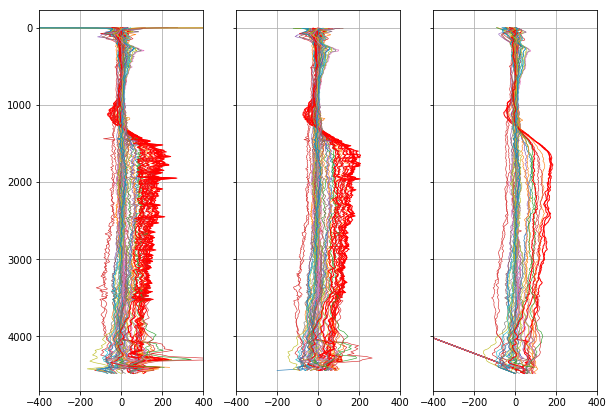

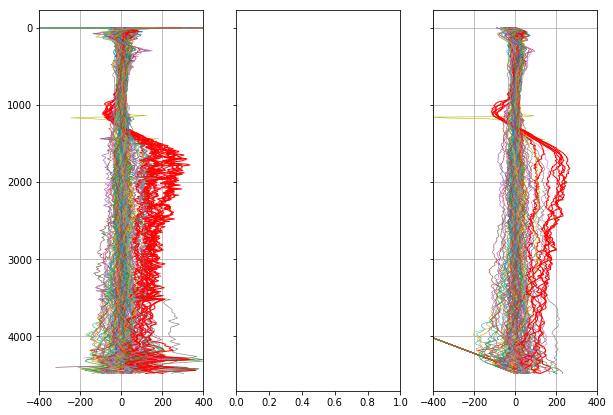

()

In [106]:
matplotlib.rcParams['figure.figsize'] = (10,7)
f, ax = plt.subplots(1, 3, sharey=True)
for i in range(np.shape(avg_sig0_per_dep)[1]):
    if len(np.intersect1d(dg_v_dive_no_0[i], edds)) < 1:
        ax[0].plot(eta_alt[:, i], grid, linewidth=0.6)
        ax[1].plot(eta_alt_2[:, i], grid, linewidth=0.6)
        ax[2].plot(-1 * eta_alt_3[:, i], grid, linewidth=0.6)
    else:
        ax[0].plot(eta_alt[:, i], grid, linewidth=1, color='r')
        ax[1].plot(eta_alt_2[:, i], grid, linewidth=1, color='r')
        ax[2].plot(-1 * eta_alt_3[:, i], grid, linewidth=1, color='r')    
ax[0].set_xlim([-400, 400])
ax[0].invert_yaxis()
ax[0].grid()
ax[1].grid()
ax[1].set_xlim([-400, 400])
ax[2].set_xlim([-400, 400])
plot_pro(ax[2])

f, ax = plt.subplots(1, 3, sharey=True)
for i in range(lon.shape[1]):
    if len(np.intersect1d(profile_tags[i], edds)) < 1:
        ax[0].plot(eta_per_prof[:, i], grid, linewidth=0.6)
        ax[2].plot(-1 * eta_per_prof_3[:, i], grid, linewidth=0.6)
    else:
        ax[0].plot(eta_per_prof[:, i], grid, linewidth=1, color='r')
        ax[2].plot(-1 * eta_per_prof_3[:, i], grid, linewidth=1, color='r')
ax[0].set_xlim([-400, 400])
ax[0].invert_yaxis()
ax[0].grid()
ax[2].set_xlim([-400, 400])
plot_pro(ax[2])

In [107]:
# FILTER VELOCITY PROFILES IF THEY ARE TOO NOISY / BAD -- ALSO HAVE TO REMOVE EQUIVALENT ETA PROFILE (non-ind profiles)
# select only velocity profiles that seem reasonable
# criteria are slope of v (dont want kinks)
# criteria: limit surface velocity to greater that 40cm/s
good_v = np.zeros(np.shape(dg_v_0)[1], dtype=bool)
for i in range(np.shape(dg_v_0)[1]):
    dv_dz = np.gradient(dg_v_0[10:-20, i], -1 * grid[10:-20])
    # print(np.nanmax(np.abs(dv_dz)))
    if (np.nanmax(np.abs(dv_dz)) < 0.003) & (np.nanmax(np.abs(eta_alt_3[20:-20, i])) < 750):  # 0.0225
        good_v[i] = True
good_v[np.abs(dg_v_0[5,:]) > 1] = False
        
avg_sig = avg_sig0_per_dep[:, good_v]
eta_alt = eta_alt_3[:, good_v]
dace_mw = dace_mw_0[good_v]
dacn_mw = dacn_mw_0[good_v]
dg_v = dg_v_0[:, good_v]
dg_v_e = dg_v_e_0[:, good_v]
dg_v_n = dg_v_n_0[:, good_v]
dg_mw_time = dg_mw_time_0[good_v]
dg_v_dive_no = dg_v_dive_no_0[good_v]
num_mw_profs = np.shape(eta_alt)[1]

# Smooth DG N2 profiles
dg_avg_N2_coarse = np.nanmean(dg_N2, axis=1)
dg_avg_N2_coarse[np.isnan(dg_avg_N2_coarse)] = dg_avg_N2_coarse[~np.isnan(dg_avg_N2_coarse)][0] - 1*10**(-5)
dg_avg_N2 = savgol_filter(dg_avg_N2_coarse, 15, 3)

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: All-NaN slice encountered
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in greater
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:25: RuntimeWarning: Mean of empty slice


In [108]:
# EAST/NORTH VELOCITY PROFILES
dg_v_e_avg = np.nanmean(dg_v_e[:, :], axis=1)
dg_v_n_avg = np.nanmean(dg_v_n[:, :], axis=1)
dz_dg_v_e_avg = np.gradient(savgol_filter(dg_v_e_avg, 15, 7), z)
dz_dg_v_n_avg = np.gradient(savgol_filter(dg_v_n_avg, 15, 7), z)

mw_time_ordered_i = np.argsort(dg_mw_time)
dg_mw_time_ordered = dg_mw_time[mw_time_ordered_i]
dg_v_e_ordered = dg_v_e[:, mw_time_ordered_i]
dg_v_n_ordered = dg_v_n[:, mw_time_ordered_i]

In [110]:
# SAVING 
savee = 1
if savee > 0:
    my_dict = {'depth': grid, 'raw_profile_tags': profile_tags, 'sa': sa, 'ct': ct, 'gamma': neutral_density, 
               'prof_lon': lon, 'prof_lat': lat,
               'profile_time': time_rec_bin, 'ref_lon': ref_lon, 'ref_lat': ref_lat, 'background_indices': bckgrds,
               'background key': bckgrds_info, 'lon_lim': lon_lim, 'lat_lim': lat_lim,
               'N2_by_season_quad': N2, 'bckgrd_sa': salin_avg, 'bckgrd_ct': cons_t_avg,
               'bckgrd_theta': theta_avg, 'bckgrd_gamma': sigma_theta_avg, 'mw_time': dg_mw_time_0, 'mw_lon': prof_lon_i,
               'mw_lat': prof_lat_i, 'mw_ct': avg_ct_per_dep, 'mw_sa': avg_sa_per_dep, 'mw_gamma': avg_sig0_per_dep,
               'eta_1': eta_alt_0, 'eta_2': eta_alt_2, 'eta_3': eta_alt_3, 'eta_per_1': eta_per_prof, 
               'eta_per_3': eta_per_prof_3, 'mw_prof': dg_v_dive_no_0,
               'good_v_ind': good_v, 'mw_time_good': dg_mw_time,
               'mw_gamma_good': avg_sig, 'eta_1_good': eta_alt_0[:, good_v], 'eta_2_good': eta_alt_2[:, good_v],
               'eta_3_good': eta_alt_3[:, good_v], 'dac_e_mw': dace_mw, 'dac_n_mw': dacn_mw,
               'dg_v_good': dg_v, 'dg_v': dg_v_0, 'dg_v_e_good': dg_v_e, 'dg_v_n_good': dg_v_n, 
               'mw_prof_good': dg_v_dive_no, 'PE_per_prof': PE_per_mass_all}
    output = open('/Users/jake/Documents/baroclinic_modes/DG/sg035_2014_initial_processing.pkl', 'wb')
    pickle.dump(my_dict, output)
    output.close()